## Spark OCR GPU image processing example

## Install spark-ocr python packge
Need specify path to `spark-ocr-assembly-[version].jar` or `secret`

In [1]:
secret = ""
license = ""
version = secret.split("-")[0]
spark_ocr_jar_path = "../../target/scala-2.11"

In [2]:
%%bash
if python -c 'import google.colab' &> /dev/null; then
    echo "Run on Google Colab!"
    echo "Install Open JDK"
    apt-get install -y openjdk-8-jdk-headless -qq > /dev/null
    java -version
fi

In [3]:
import sys
import os

if 'google.colab' in sys.modules:
  os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
  os.environ["PATH"] = os.environ["JAVA_HOME"] + "/bin:" + os.environ["PATH"]

In [ ]:
# install from PYPI using secret
%pip install spark-ocr==$version+spark32 --extra-index-url=https://pypi.johnsnowlabs.com/$secret --upgrade

In [5]:
# or install from local path
#%pip install --upgrade ../../python/dist/spark-ocr-3.1.0.spark30.tar.gz

## Initialization of spark session

In [6]:
from pyspark.sql import SparkSession
from sparkocr import start
import os

if license:
    os.environ['JSL_OCR_LICENSE'] = license

spark = start(secret=secret, jar_path=spark_ocr_jar_path)
spark

Spark version: 3.2.1
Spark NLP version: 4.0.0
Spark NLP for Healthcare version: 4.0.0
Spark OCR version: 4.0.0



## Imports

In [7]:
from pyspark.ml import PipelineModel
from pyspark.sql import functions as F

from sparkocr.transformers import *
from sparkocr.enums import *
from sparkocr.utils import display_image, display_images
from sparkocr.metrics import score

## Read image

In [8]:
import pkg_resources
imagePath = pkg_resources.resource_filename('sparkocr', 'resources/ocr/images/check.jpg')
image_raw = spark.read.format("binaryFile").load(imagePath)
image_df = BinaryToImage().transform(image_raw)


    Image #0:
    Origin: file:/home/jose/.local/lib/python3.7/site-packages/sparkocr/resources/ocr/images/check.jpg
    Resolution: 199 dpi
    Width: 582 px
    Height: 744 px
    Mode: ImageType.TYPE_BYTE_GRAY
    Number of channels: 1


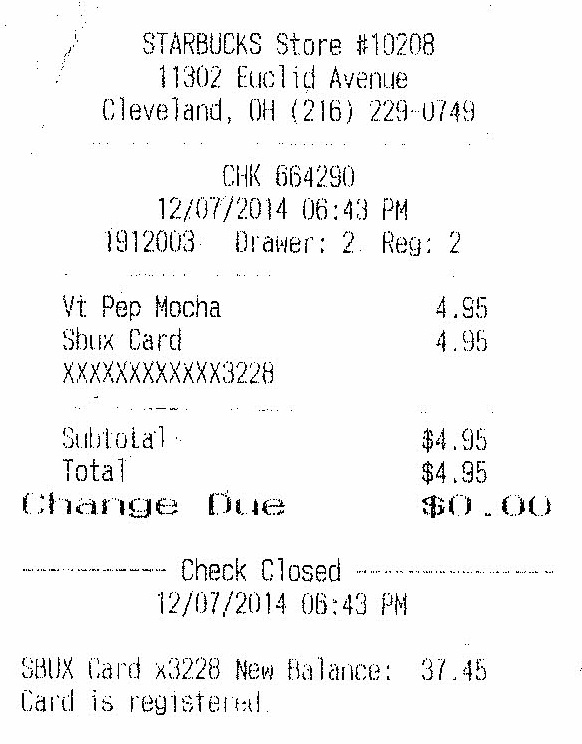

In [9]:
display_images(image_df)

## Scaling


    Image #0:
    Origin: file:/home/jose/.local/lib/python3.7/site-packages/sparkocr/resources/ocr/images/check.jpg
    Resolution: 199 dpi
    Width: 1164 px
    Height: 1488 px
    Mode: ImageType.TYPE_BYTE_BINARY
    Number of channels: 3


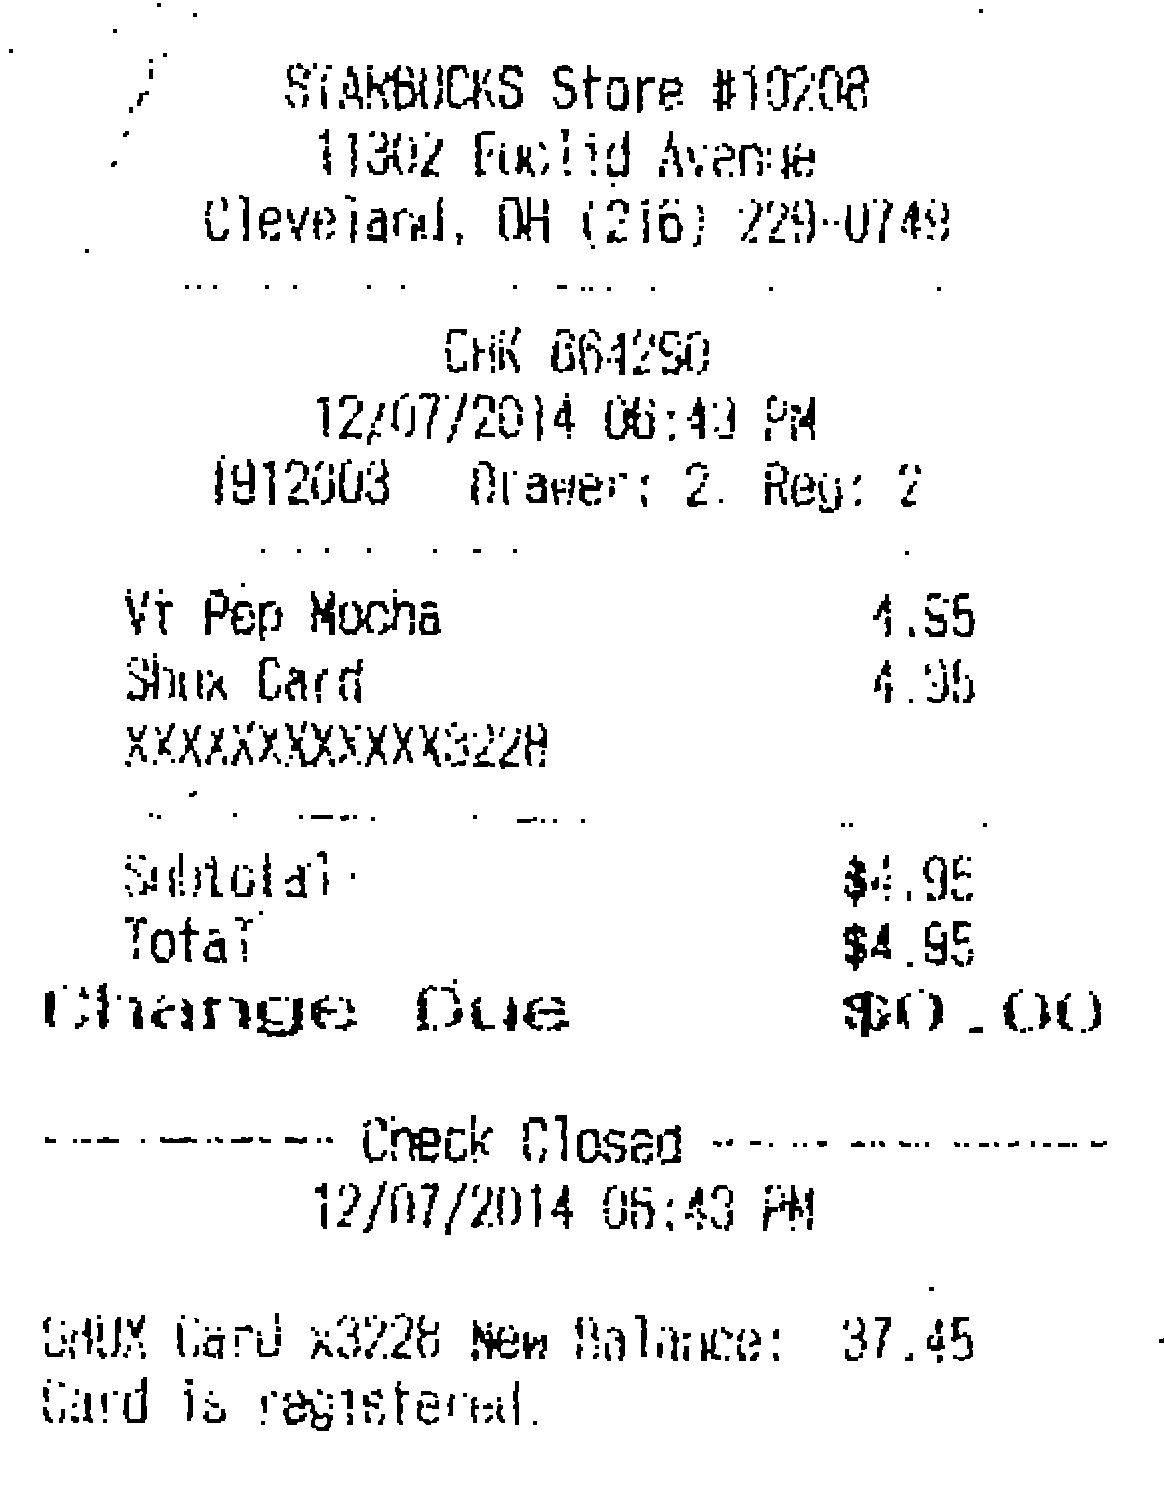

In [10]:
scaled_image_df = GPUImageTransformer() \
.addErodeTransform(1,1)\
.addScalingTransform(2) \
.setInputCol("image") \
.setOutputCol("scaled_image") \
.transform(image_df)

display_images(scaled_image_df, "scaled_image")

## Image Adaptive Thresholding on GPU


    Image #0:
    Origin: file:/home/jose/.local/lib/python3.7/site-packages/sparkocr/resources/ocr/images/check.jpg
    Resolution: 199 dpi
    Width: 582 px
    Height: 744 px
    Mode: ImageType.TYPE_BYTE_BINARY
    Number of channels: 3


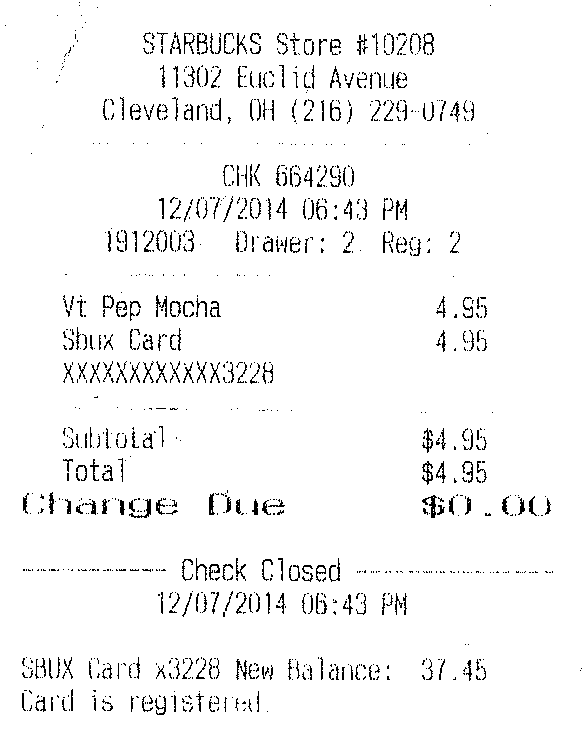

In [11]:
thresholded_image = GPUImageTransformer() \
.addOtsuTransform()\
.setInputCol("image") \
.setOutputCol("thresholded_image") \
.transform(image_df)

display_images(thresholded_image, "thresholded_image")

## Erosion


    Image #0:
    Origin: file:/home/jose/.local/lib/python3.7/site-packages/sparkocr/resources/ocr/images/check.jpg
    Resolution: 199 dpi
    Width: 582 px
    Height: 744 px
    Mode: ImageType.TYPE_BYTE_BINARY
    Number of channels: 3


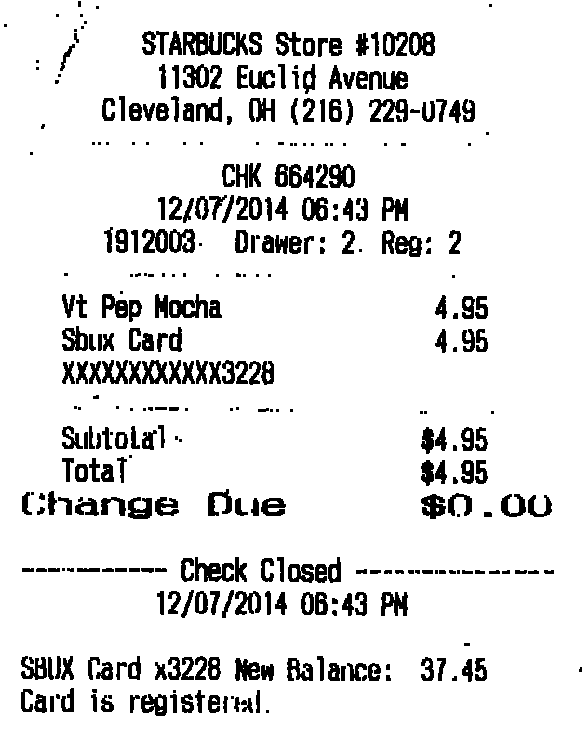

In [12]:
eroded_image = GPUImageTransformer() \
.addErodeTransform(1,1)\
.setInputCol("image") \
.setOutputCol("eroded_image") \
.transform(image_df)

display_images(eroded_image, "eroded_image")

## Dilation


    Image #0:
    Origin: file:/home/jose/.local/lib/python3.7/site-packages/sparkocr/resources/ocr/images/check.jpg
    Resolution: 199 dpi
    Width: 582 px
    Height: 744 px
    Mode: ImageType.TYPE_BYTE_BINARY
    Number of channels: 3


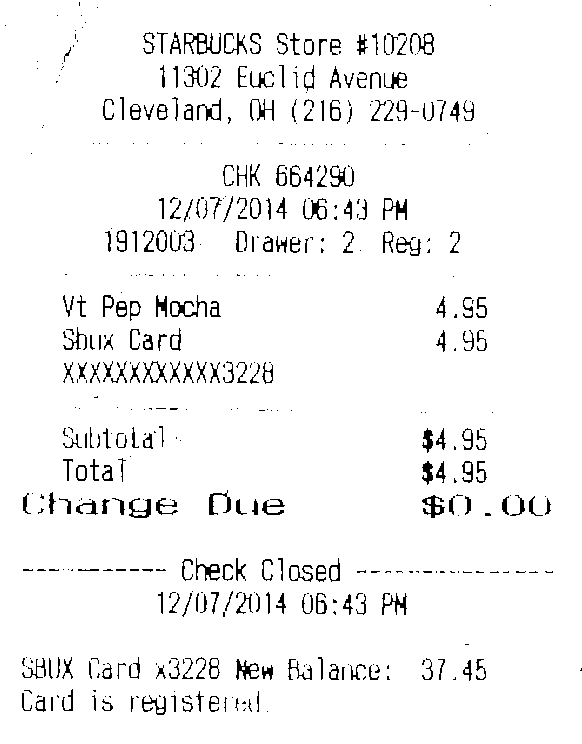

In [13]:
dilated_image = GPUImageTransformer() \
.addDilateTransform(1,1)\
.setInputCol("eroded_image") \
.setOutputCol("dilated_image") \
.transform(eroded_image)

display_images(dilated_image, "dilated_image")

## Multiple chained transforms


    Image #0:
    Origin: file:/home/jose/.local/lib/python3.7/site-packages/sparkocr/resources/ocr/images/check.jpg
    Resolution: 199 dpi
    Width: 4656 px
    Height: 5952 px
    Mode: ImageType.TYPE_BYTE_BINARY
    Number of channels: 3


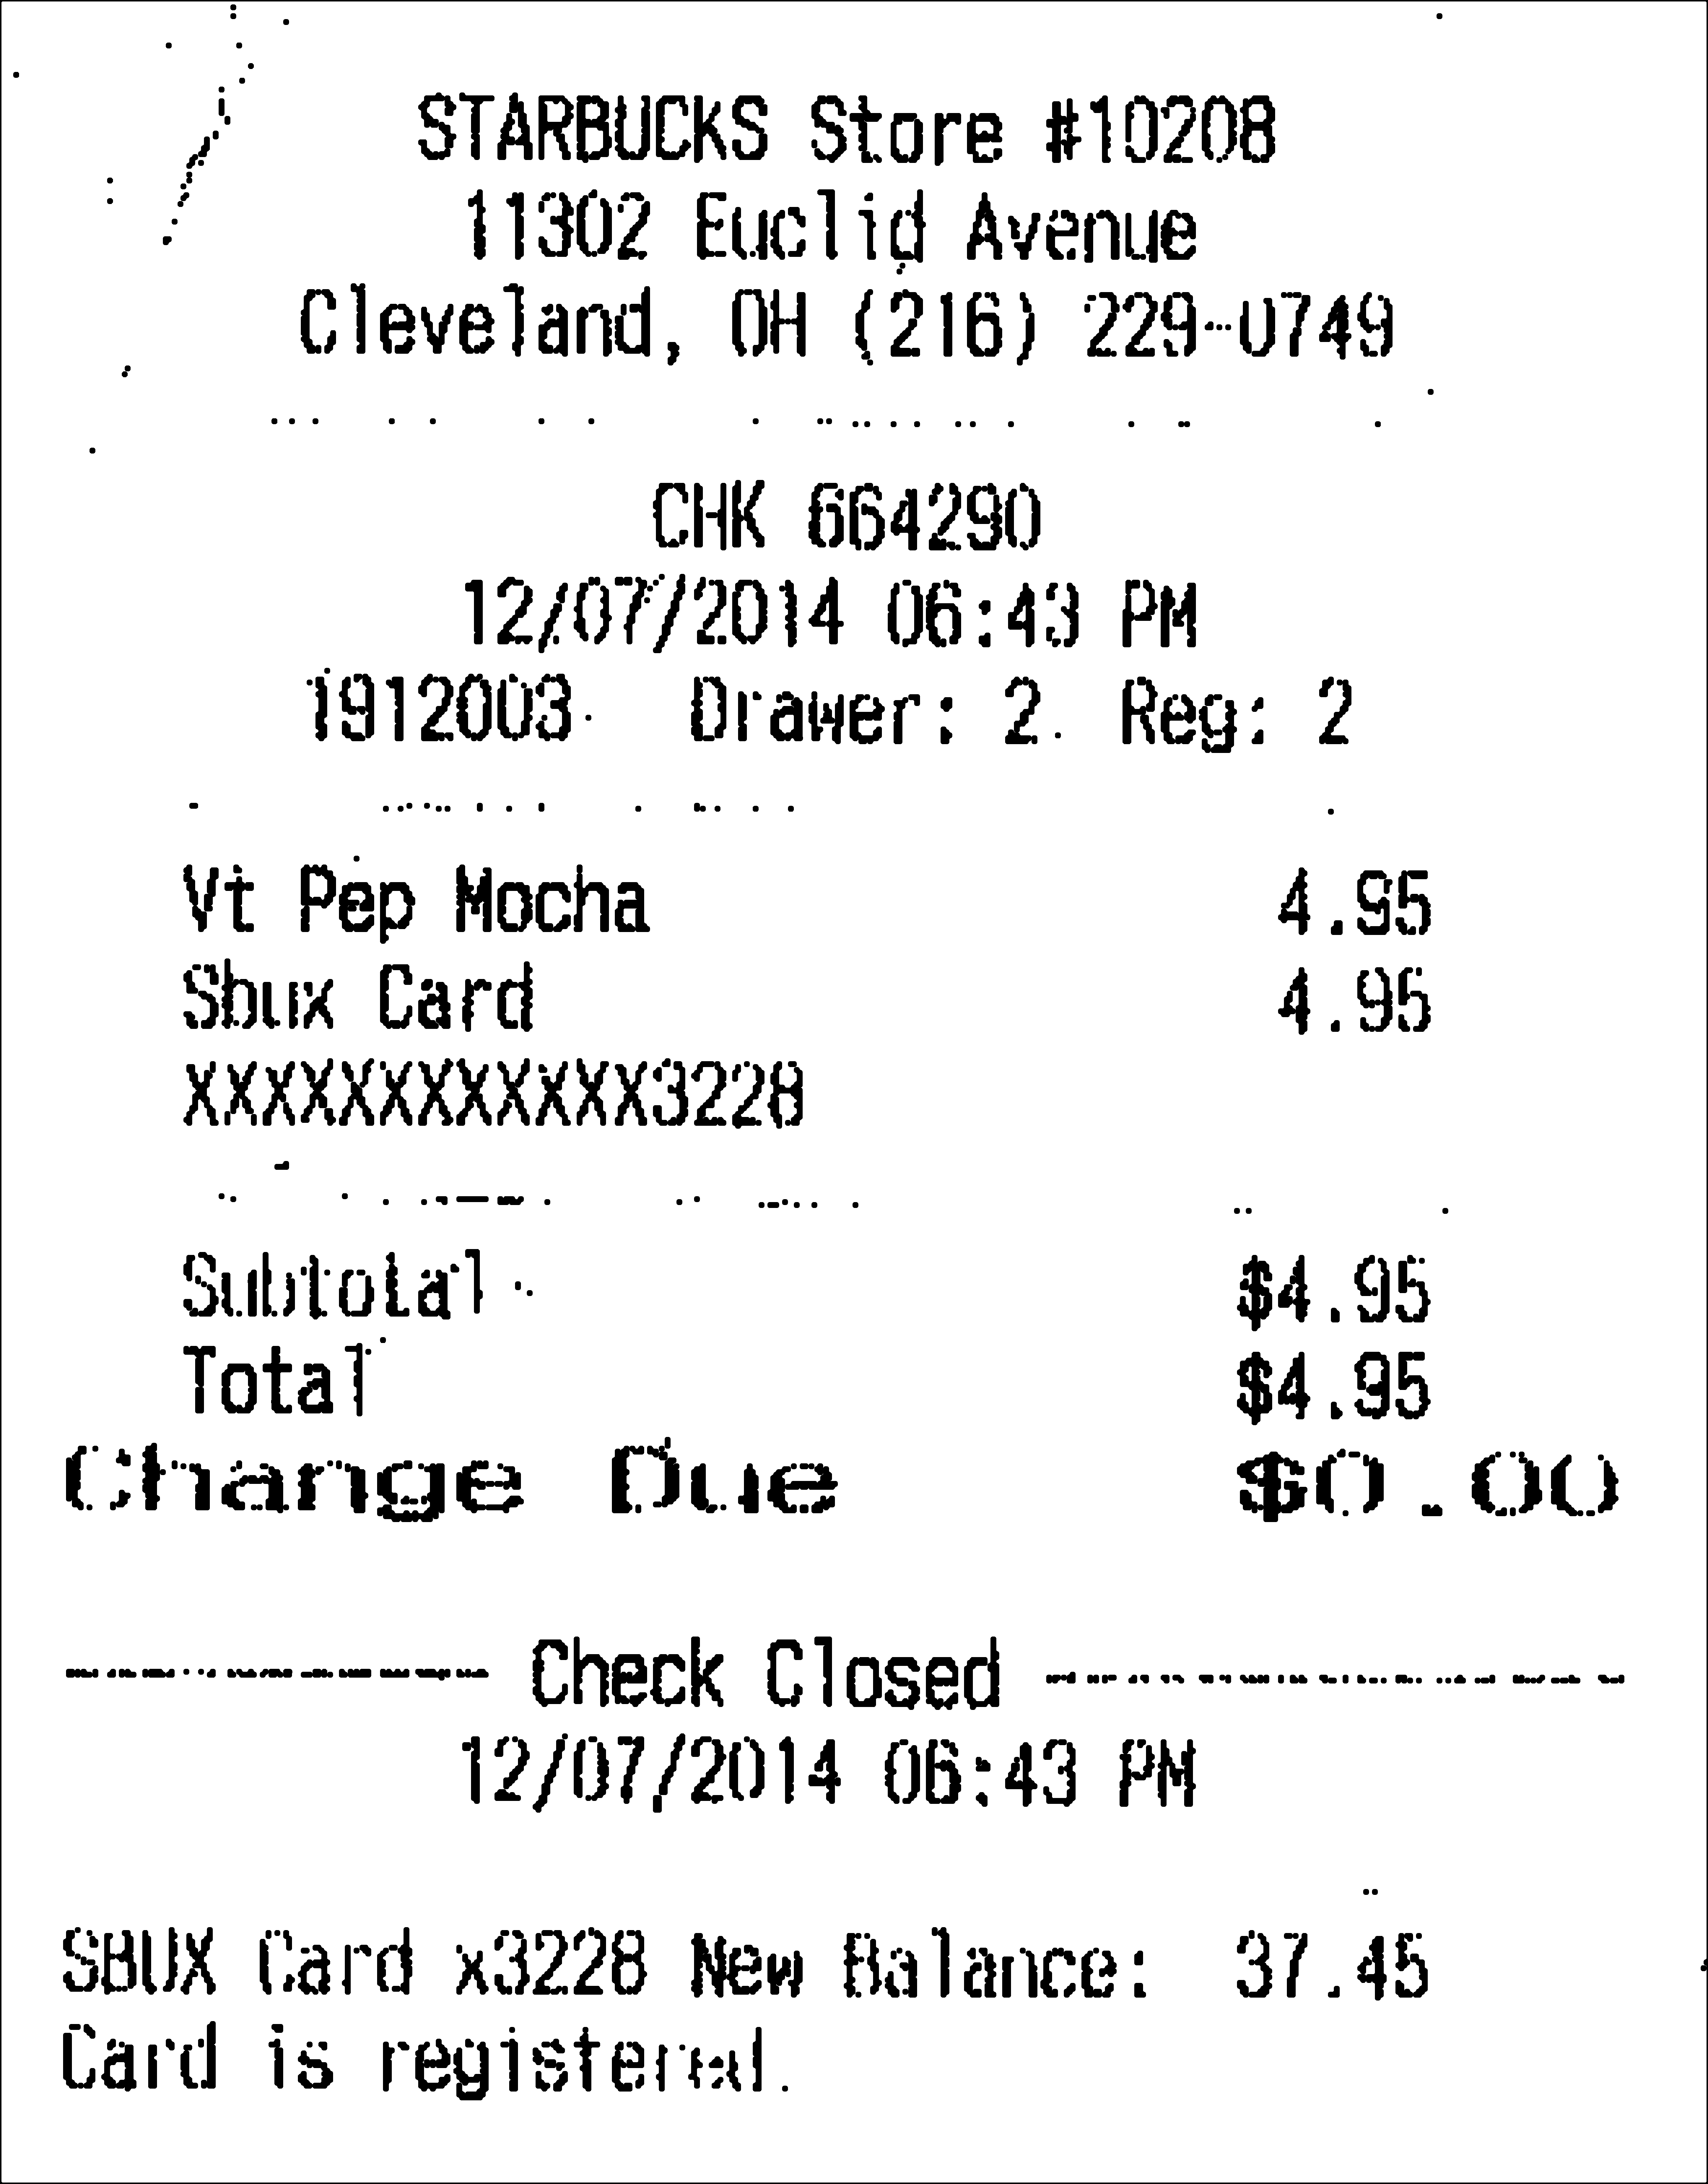

In [14]:
multiple_image = GPUImageTransformer() \
.addScalingTransform(8) \
.addOtsuTransform() \
.addErodeTransform(3, 3) \
.setInputCol("image") \
.setOutputCol("multiple_image") \
.transform(image_df)

display_images(multiple_image, "multiple_image")

## Metrics
Compare performance of GPU transforms vs. regular Transformer based pipeline.

In [15]:
from sparkocr.enums import *

scaler = ImageScaler()\
    .setInputCol("image")\
    .setOutputCol("scaled_image")\
    .setScaleFactor(8.0)

adaptive_thresholding = ImageAdaptiveBinarizer() \
    .setInputCol("scaled_image") \
    .setOutputCol("corrected_image") \
    .setMethod(ThresholdingMethod.OTSU)

erosion = ImageMorphologyOperation() \
    .setKernelShape(KernelShape.SQUARE) \
    .setKernelSize(1) \
    .setOperation("erosion") \
    .setInputCol("corrected_image") \
    .setOutputCol("eroded_image")


pipeline = PipelineModel(stages=[
    scaler,
    adaptive_thresholding,
    erosion
])

## Common Spark-OCR transforms

In [16]:
%%time
for _ in range(10):
    pipeline.transform(image_df).select("eroded_image").collect()

CPU times: user 188 ms, sys: 52 ms, total: 240 ms
Wall time: 31 s


## GPU transforms

In [17]:
%%time
for _ in range(10):
    multiple_image.select("multiple_image").collect()

CPU times: user 101 ms, sys: 20.4 ms, total: 122 ms
Wall time: 5.04 s


## OCR results

In [18]:
result = ImageToText() \
.setInputCol("multiple_image") \
.setOutputCol("text") \
.setConfidenceThreshold(35) \
.transform(multiple_image)

print("\n".join([row.text for row in result.select("text").collect()]))

 

f STARBUCKS Store #10208
e 11302 Euclid Avenue
Gleve land, OH (216) 229-U749

CHK 664290
12/07/2014 06:43 PM
912003 drawer: 2. Reg: 2

Vi Pap Mocha 4.95

Spoux Card 4.95

KARAKARAXXANS226

Subtotal - . $4.95

Total $4 95
Change OHuvue $0.00

SBUX Card x3228 New Balance: 37.45
Card is registered.

